# Dnn - A Hands-on Challenge - Home Work 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
%qtconsole


# Load data 

In [2]:
def resample(x):
    return x.reset_index(level=['ConnectionID'], drop=True).resample(str(15) + 'min', label='right').last().ffill()

glucose = pd.read_pickle('GlucoseValues.df')
glucose = glucose.sort_index().groupby(level='ConnectionID').apply(resample)

blood = pd.read_pickle('BloodTests.df')
measurements = pd.read_pickle('Measurements.df')
bac = pd.read_pickle('BacterialSpecies.df')

exercise = pd.read_pickle('Exercises.df')
test_food = pd.read_pickle('TestFoods.df')
meals = pd.read_pickle('Meals.df')
sleep = pd.read_pickle('Sleep.df')

x_y = pd.read_pickle('x_y.df')

# Glucose 
## Time series of glucose of a random person : plot curve for each day 

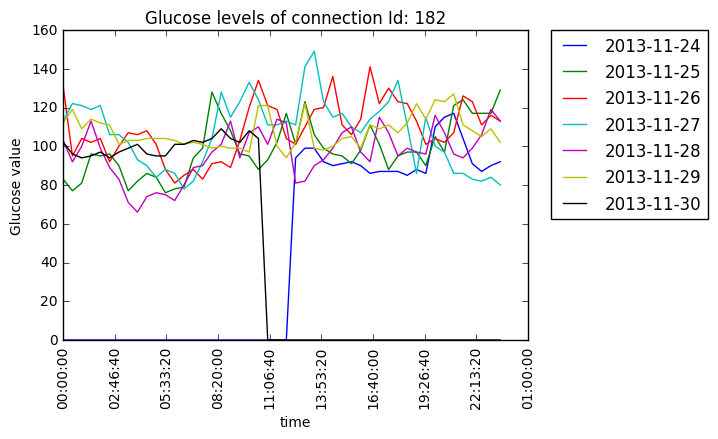

In [3]:
# pick connection id 
n = (x_y.index.get_level_values(0).unique().shape[0])
con_id = np.random.randint(n)
glucose_con_id = glucose.loc[con_id]


# Arrange the glucose to fit 24 hours for each day 

day2list = lambda group: group.reindex(pd.date_range(group.index[0].date(), periods=24*2, freq='30min'))
glucose_per_day = glucose_con_id.groupby(glucose_con_id.index.day, sort=False).apply(day2list)
glucose_per_day = glucose_per_day.fillna(0)

# plot glucose levels 

ids = glucose_per_day.index.get_level_values(0).unique()
x = glucose_per_day.loc[ids[0]].index.time

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in ids:
    y = glucose_per_day.loc[i].values.flatten()
    ax.plot(x, y,label= glucose_per_day.loc[i].index[0].date())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Glucose value')
plt.title("Glucose levels of connection Id: {}".format(con_id))

## Histogram of diffrences in glucose level 

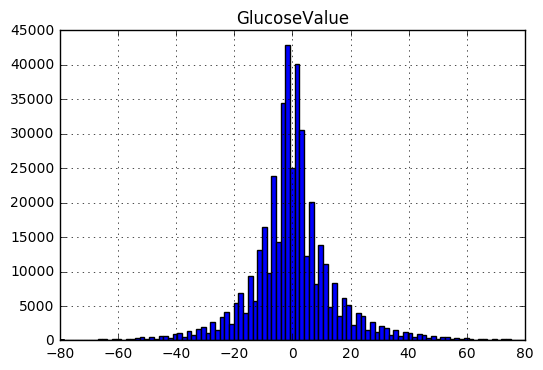

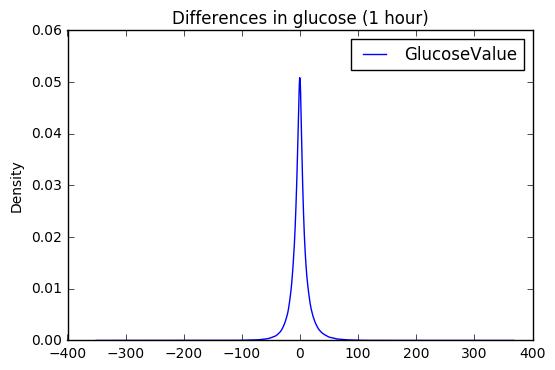

In [13]:
group2differences = lambda group: (group.shift(-int(60 / 15)) - group)
glucose_differences = (glucose.groupby(level='ConnectionID').apply(group2differences)).dropna()
glucose_differences.hist(bins=np.linspace(-80,80,100))
glucose_differences.plot(bins=np.linspace(-80,80,100))
plt.title('Differences in glucose (1 hour)')

# Bacterial Species
## Plotting number of bac per person and number of persons per bac

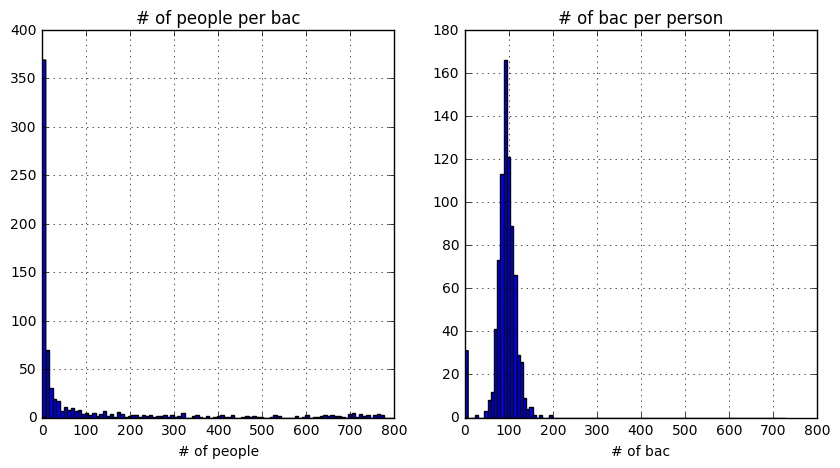

In [5]:
bac = pd.read_pickle('BacterialSpecies.df')
num_of_bac = bac.columns.shape[0]
num_of_people = bac.index.shape[0]


fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
bac.count(0).hist(bins=np.linspace(0,num_of_people,100), ax=ax1)
ax1.set_title("# of people per bac")
ax1.set_xlabel("# of people")


ax2 = fig.add_subplot(1,2,2)
bac.count(1).hist(bins=np.linspace(0,num_of_bac,100), ax=ax2)
ax2.set_title("# of bac per person")
ax2.set_xlabel("# of bac")



In [6]:
# Given a data frame returns the name of the row that is most similar to gaussian distribution
def get_most_normal_feature(df):
    df_noormalized = (df - df.mean()) / df.std()

    column2pvalue = lambda column: stats.stats.kstest((column.dropna()), cdf='norm')[1]
    return df_noormalized.apply(column2pvalue).argmax()


# Blood tests  

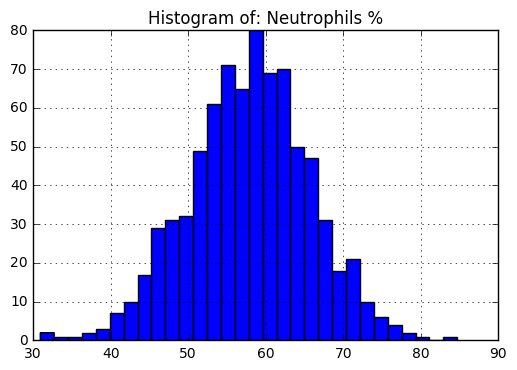

In [7]:
blood = pd.read_pickle('BloodTests.df')

feature_name = get_most_normal_feature(blood)
blood[feature_name].hist(bins = 30)
plt.title('Histogram of: {}'.format(feature_name))

# Measurments


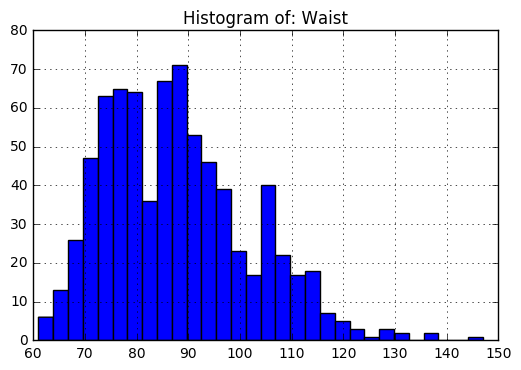

In [8]:
measurements = pd.read_pickle('Measurements.df')
measurements = measurements._get_numeric_data()
feature_name = get_most_normal_feature(measurements)
measurements[feature_name].hist(bins = 30)
plt.title('Histogram of: {}'.format(feature_name))

# Meals 


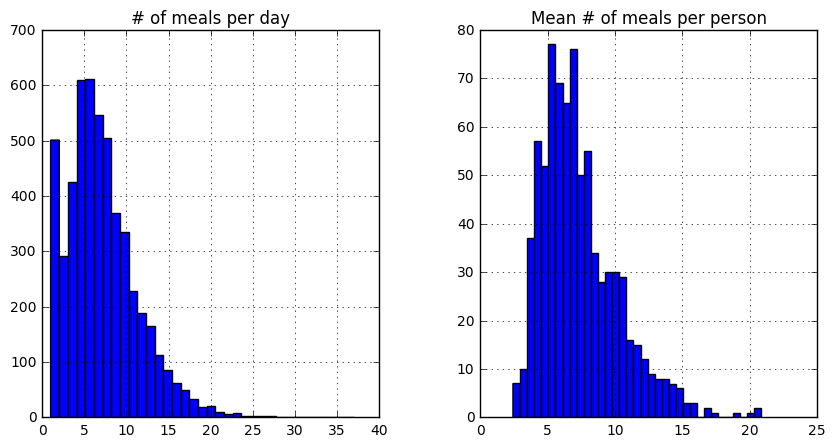

In [9]:
meals = pd.read_pickle('Meals.df')

meals_per_day = meals['Timestamp'].reset_index().groupby([pd.Grouper(key='ConnectionID'),pd.Grouper(key='Timestamp',freq='1D')]).count()
meals_per_day.columns = ['NumOfMeals']

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
meals_per_day.hist(bins=35, ax=ax1)
ax1.set_title("# of meals per day")


ax2 = fig.add_subplot(1,2,2)
meals_per_day.groupby(level='ConnectionID').mean().hist(bins=35, ax=ax2)
ax2.set_title('Mean # of meals per person')

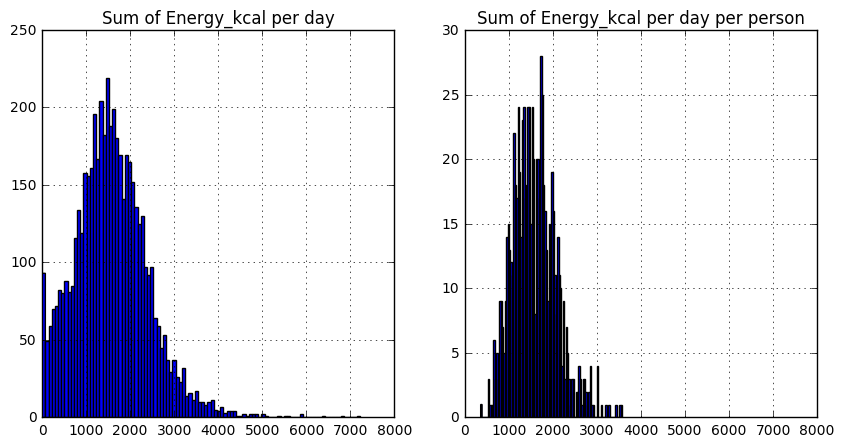

In [75]:
kcal_sum_per_day=meals.reset_index().groupby([pd.Grouper(key='ConnectionID'),pd.Grouper(key='Timestamp',freq='1D')]).sum()

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,5))
kcal_sum_per_day['Energy_kcal'].hist(bins=100, ax=axes[0])
axes[0].set_title("Sum of Energy_kcal per day")

kcal_sum_per_day['Energy_kcal'].groupby(level='ConnectionID').mean().hist(bins=100, ax=axes[1])
axes[1].set_title('Sum of Energy_kcal per day per person')

## Exercise

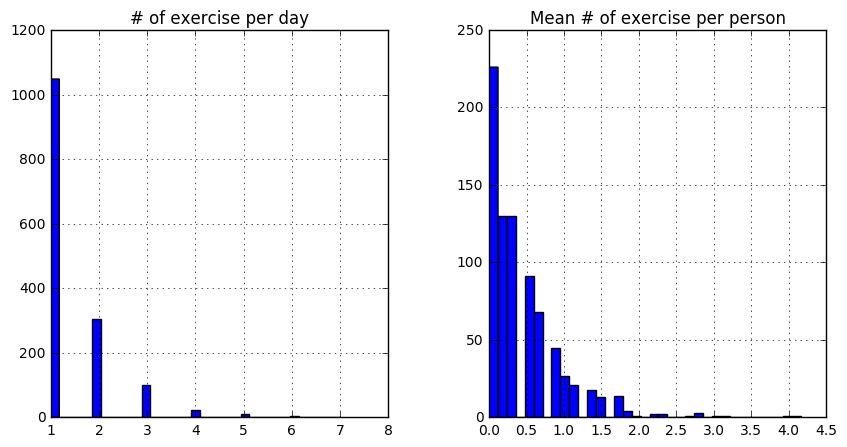

In [11]:
exercise = pd.read_pickle('Exercises.df')

exercise_per_day = exercise['Timestamp'].reset_index().groupby([pd.Grouper(key='ConnectionID'),pd.Grouper(key='Timestamp',freq='1D')]).count()
exercise_per_day.columns = ['NumOfExercise']

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
exercise_per_day.hist(bins=35, ax=ax1)
ax1.set_title("# of exercise per day")


ax2 = fig.add_subplot(1,2,2)
mean_exercise_per_id = exercise_per_day.groupby(level='ConnectionID').apply(lambda x: np.divide(np.sum(x),6))
con_id_x_y = set(x_y.index.get_level_values('ConnectionID').unique())
con_id_exercise = set(exercise.index.get_level_values('ConnectionID').unique())
no_exercise_con_id = con_id_x_y-con_id_exercise
mean_exercise_per_id = mean_exercise_per_id.append(pd.DataFrame(data={'NumOfExercise':0},index=no_exercise_con_id))

mean_exercise_per_id.hist(bins=35, ax=ax2)
ax2.set_title('Mean # of exercise per person')

## Sleep

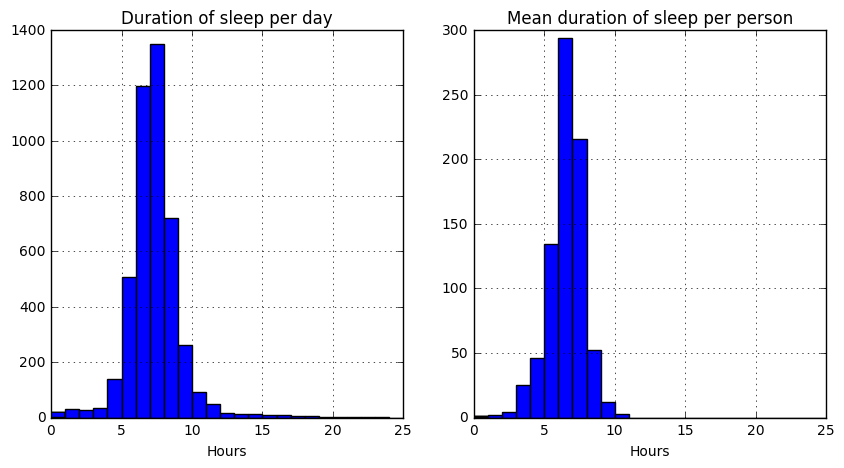

In [12]:
sleep = pd.read_pickle('Sleep.df')
sleep = sleep.dropna()

sleep['wakeup_time'] = sleep['wakeup_time'].values.astype('datetime64[ns]')
sleep['sleep_time'] = sleep['sleep_time'].values.astype('datetime64[ns]')
sleep['duration'] = sleep['wakeup_time'] - sleep['sleep_time']

sleep_per_day =sleep.reset_index().groupby([pd.Grouper(key='ConnectionID'),pd.Grouper(key='wakeup_time',freq='1D')]).apply(lambda x : np.sum(x.duration))
sleep_per_day = pd.DataFrame(sleep_per_day,columns=['Duration'])
sleep_per_day['Duration_hours'] = sleep_per_day['Duration'].apply(lambda x: x.seconds//3600)
sleep_per_day['Duration_minutes'] =  sleep_per_day['Duration'].apply(lambda x: (x.seconds//60))

fig = plt.figure(figsize=(10,5))
bins = np.linspace(0, 25, 26)

ax1 = fig.add_subplot(1,2,1)
sleep_per_day['Duration_hours'].hist(bins=bins, ax=ax1)
ax1.set_title("Duration of sleep per day")
ax1.set_xlabel("Hours")

ax2 = fig.add_subplot(1,2,2)
mean_sleep_per_id = sleep_per_day['Duration_hours'].groupby(level='ConnectionID').apply(lambda x: np.divide(np.sum(x),6))
mean_sleep_per_id.hist(bins=bins, ax=ax2)
ax2.set_title("Mean duration of sleep per person")
ax2.set_xlabel("Hours")


